# Principal Component Regression 

In [1]:
import pandas as pd 
import numpy as np 

## Setting Up the Data 

In [2]:
df = pd.read_csv('modeling_data.csv')
print(df.shape)
df.head()

(687, 17)


,TEAM_SEASON,LS_MIN,LS_EFG_PCT,LS_FTA_RATE,LS_TM_TOV_PCT,LS_OREB_PCT,LS_OPP_EFG_PCT,LS_OPP_FTA_RATE,LS_OPP_TOV_PCT,LS_OPP_OREB_PCT,HEIGHT_INCHES,WEIGHT,EXP,LS_WIN_PCT,PO_WINS,TEAM_ID,TEAM_NAME
0,1610612737_2001-02,18.097566,0.461098,0.324734,0.163691,0.266759,0.476202,0.355158,0.153661,0.286407,80.000000,224.615385,3.153846,0.305,0.0,1610612737,Hawks
1,1610612737_2002-03,17.691622,0.459190,0.296291,0.165052,0.252703,0.490334,0.332949,0.151786,0.301969,79.187500,224.562500,4.125000,0.402,0.0,1610612737,Hawks
2,1610612737_2003-04,16.653165,0.467314,0.320842,0.167814,0.275845,0.480911,0.323210,0.142232,0.289654,80.133333,227.000000,4.000000,0.427,0.0,1610612737,Hawks
3,1610612737_2004-05,13.812289,0.432378,0.324171,0.166552,0.250593,0.494104,0.375538,0.167617,0.286726,79.769231,225.923077,5.076923,0.341,0.0,1610612737,Hawks
4,1610612737_2005-06,21.489895,0.463531,0.327702,0.170385,0.274347,0.510406,0.369320,0.144927,0.280918,78.846154,223.615385,1.923077,0.159,0.0,1610612737,Hawks


In [3]:
def modeling_data_setup(data,test_seasons,this_season,model_type):
    # returns x, xtest, y, ytest, this season's data 
    
    target = 'PO_WINS'
    
    import pandas as pd
    import numpy as np 
    
    if type(test_seasons) == int:
        test_seasons = [test_seasons]
    elif type(test_seasons) == list:
        test_seasons = test_seasons
    else:
        raise TypeError("ERROR! Please enter the test_seasons as type int or list (of int)")
        
    for i in test_seasons:
        if type(i)!=int:
            raise TypeError("ERROR! Please enter the test_seasons as type int or list (of int)")
    
    import pandas as pd
    import numpy as np 
    from sklearn.model_selection import train_test_split
    
    print('columns to drop:')
    drop_cols = ['TEAM_SEASON','TEAM_ID','TEAM_NAME','PO_WINS','SEASON']
    print(drop_cols)
    
    print('Creating SEASON for splitting')
    ids = data['TEAM_SEASON'].str.split('_')
    season = [int(x[1][0:4]) for x in ids]
    data['SEASON'] = season
    
    print("Dropping this season: {}".format(this_season))
    current = data[data['SEASON']==this_season].copy()
    
    print('Dropping the Pelicans and Hornets first season')
    data = data[~data['LS_WIN_PCT'].isna()].copy()
    
    test = data[data['SEASON'].isin(test_seasons)].copy()
    train = data[(~data['SEASON'].isin(test_seasons))&(data['SEASON']!=this_season)].copy()
    ytest = test[target].copy()
    ytrain = train[target].copy()
    xtest = test.drop(drop_cols,axis=1)
    xtrain = train.drop(drop_cols,axis=1)
    
    print("Returning: Train, Test, X Train, X Test, Y Train, Y Test, and the Upcoming Season")
    
    return train,test,xtrain,xtest,ytrain,ytest,current

In [4]:
train, test, x_train, x_test, y_train, y_test, upcoming = modeling_data_setup(df,[2022],2023,'reg')

columns to drop:
['TEAM_SEASON', 'TEAM_ID', 'TEAM_NAME', 'PO_WINS', 'SEASON']
Creating SEASON for splitting
Dropping this season: 2023
Dropping the Pelicans and Hornets first season
Returning: Train, Test, X Train, X Test, Y Train, Y Test, and the Upcoming Season


In [5]:
id_cols = ['TEAM_SEASON','TEAM_ID','TEAM_NAME','SEASON']
train_ids = train[id_cols].copy()
test_ids = test[id_cols].copy()

## Modeling

In [6]:
# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for feature reduction 
from sklearn import feature_selection
from sklearn import pipeline

# for the modeling
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import sklearn

# getting rid of the warnings 
import warnings
warnings.filterwarnings('ignore')

In [7]:
# performing preprocessing part
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [8]:
# Applying PCA function on training
# and testing set of X component

from sklearn.decomposition import PCA

# looping through to get optimal number of components 
cvs = []
for i in range(1,x_train.shape[1]):
    pca = PCA(n_components = i)

    x_trainC = pca.fit_transform(x_train)
    x_testC = pca.transform(x_test)

    explained_variance = pca.explained_variance_ratio_


    param_grid = {
                    'alpha'     : np.arange(0,2,0.01),
                    'l1_ratio'  :  np.arange(0,.4,0.01),
                    'tol'       : [0.0001,0.001],
                    'fit_intercept': [True]
                }
    eNet = ElasticNet(max_iter=10000,random_state=41)
    clf = GridSearchCV(eNet, 
                               param_grid, 
                               scoring='neg_root_mean_squared_error', 
                               cv = 5,
                               return_train_score=True,
                               verbose = 1, 
                               n_jobs = -1
                      )
    # Fitting the model 
    clf.fit(x_trainC,y_train)
    
    print(i)
    print("Tuned Hyperparameters :", clf.best_params_)
    print("Best Score :",clf.best_score_)
    # storing the CV results 
    cv = pd.DataFrame(clf.cv_results_)
    cv['ncomp'] = i
    cvs.append(cv)

Fitting 5 folds for each of 16000 candidates, totalling 80000 fits
1
Tuned Hyperparameters : {'alpha': 0.46, 'fit_intercept': True, 'l1_ratio': 0.39, 'tol': 0.0001}
Best Score : -4.304481167223213
Fitting 5 folds for each of 16000 candidates, totalling 80000 fits
2
Tuned Hyperparameters : {'alpha': 0.01, 'fit_intercept': True, 'l1_ratio': 0.39, 'tol': 0.0001}
Best Score : -3.683559791074253
Fitting 5 folds for each of 16000 candidates, totalling 80000 fits
3
Tuned Hyperparameters : {'alpha': 0.15, 'fit_intercept': True, 'l1_ratio': 0.39, 'tol': 0.0001}
Best Score : -3.694048410666936
Fitting 5 folds for each of 16000 candidates, totalling 80000 fits
4
Tuned Hyperparameters : {'alpha': 0.14, 'fit_intercept': True, 'l1_ratio': 0.39, 'tol': 0.0001}
Best Score : -3.6942816056293024
Fitting 5 folds for each of 16000 candidates, totalling 80000 fits
5
Tuned Hyperparameters : {'alpha': 0.19, 'fit_intercept': True, 'l1_ratio': 0.39, 'tol': 0.0001}
Best Score : -3.6996938821167484
Fitting 5 fol

In [9]:
cv_pre = pd.concat(cvs)

In [10]:
cv_pre.sort_values('mean_test_score',inplace=True,ascending=False)

In [11]:
cv_pre[['mean_test_score','ncomp','params']]

,mean_test_score,ncomp,params
159,-3.683560,2,"{'alpha': 0.01, 'fit_intercept': True, 'l1_rat..."
158,-3.683560,2,"{'alpha': 0.01, 'fit_intercept': True, 'l1_rat..."
157,-3.683560,2,"{'alpha': 0.01, 'fit_intercept': True, 'l1_rat..."
156,-3.683560,2,"{'alpha': 0.01, 'fit_intercept': True, 'l1_rat..."
155,-3.683560,2,"{'alpha': 0.01, 'fit_intercept': True, 'l1_rat..."
...,...,...,...
56,-4.307817,1,"{'alpha': 0.0, 'fit_intercept': True, 'l1_rati..."
57,-4.307817,1,"{'alpha': 0.0, 'fit_intercept': True, 'l1_rati..."
58,-4.307817,1,"{'alpha': 0.0, 'fit_intercept': True, 'l1_rati..."
59,-4.307817,1,"{'alpha': 0.0, 'fit_intercept': True, 'l1_rati..."


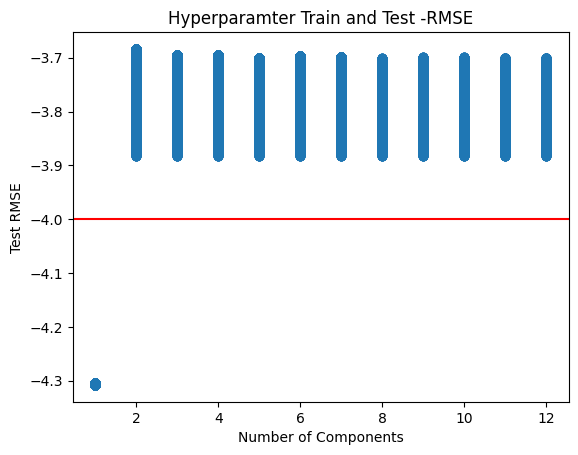

In [12]:
#Plotting the test and train gini to select best parameter
import matplotlib.pyplot as plt
plt.scatter(cv_pre['ncomp'],cv_pre['mean_test_score'] )
plt.axhline(0.-4, color='r', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Test RMSE')
#for i in range(cv.shape[0]):
#    plt.text(x=cv['mean_train_score'][i],y=cv['mean_test_score'][i]+0.03,s=cv['rank_test_score'][i],fontdict=dict(size=5))
plt.title('Hyperparamter Train and Test -RMSE')
plt.show()

In [13]:
optcomp = cv_pre[cv_pre['mean_test_score']==max(cv_pre['mean_test_score'])].sort_values('ncomp',ascending=False).head(1)['ncomp'].iloc[0]
optcomp

2

In [14]:
pca = PCA(n_components = optcomp)

x_trainC = pca.fit_transform(x_train)
x_testC = pca.transform(x_test)

explained_variance = pca.explained_variance_ratio_

clf = GridSearchCV(eNet, 
                           param_grid, 
                           scoring='neg_root_mean_squared_error', 
                           cv = 5,
                           return_train_score=True,
                           verbose = 10, 
                           n_jobs = -1
                  )

In [15]:
# Fitting the model 
clf.fit(x_trainC,y_train)

print("Tuned Hyperparameters :", clf.best_params_)
print("Best Score :",clf.best_score_)

Fitting 5 folds for each of 16000 candidates, totalling 80000 fits
Tuned Hyperparameters : {'alpha': 0.01, 'fit_intercept': True, 'l1_ratio': 0.39, 'tol': 0.0001}
Best Score : -3.6835471564075837


In [16]:
# storing the CV results 
cv = pd.DataFrame(clf.cv_results_)

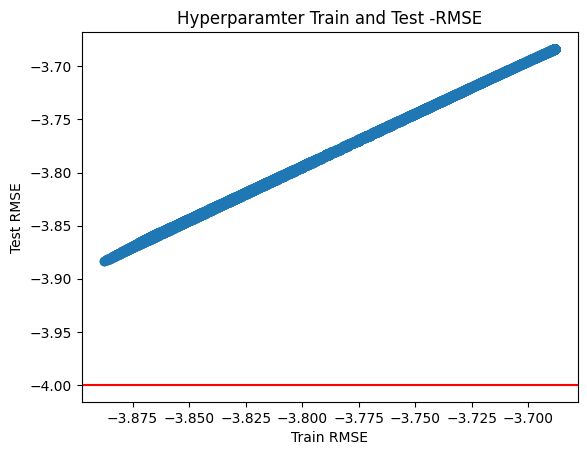

In [17]:
#Plotting the test and train gini to select best parameter
import matplotlib.pyplot as plt
plt.scatter(cv['mean_train_score'],cv['mean_test_score'] )
plt.axhline(0.-4, color='r', linestyle='-')
plt.xlabel('Train RMSE')
plt.ylabel('Test RMSE')
#for i in range(cv.shape[0]):
#    plt.text(x=cv['mean_train_score'][i],y=cv['mean_test_score'][i]+0.03,s=cv['rank_test_score'][i],fontdict=dict(size=5))
plt.title('Hyperparamter Train and Test -RMSE')
plt.show()

In [18]:
cv.sort_values('mean_test_score',ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_intercept,param_l1_ratio,param_tol,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
159,0.009721,0.016877,0.000483,0.000015,0.01,True,0.39,0.001,"{'alpha': 0.01, 'fit_intercept': True, 'l1_rat...",-3.963285,...,-3.683547,0.542655,1,-3.626930,-3.453930,-3.819732,-3.714446,-3.826177,-3.688243,0.138321
158,0.001301,0.000060,0.000481,0.000010,0.01,True,0.39,0.0001,"{'alpha': 0.01, 'fit_intercept': True, 'l1_rat...",-3.963285,...,-3.683547,0.542655,1,-3.626930,-3.453930,-3.819732,-3.714446,-3.826177,-3.688243,0.138321
157,0.001258,0.000012,0.000478,0.000009,0.01,True,0.38,0.001,"{'alpha': 0.01, 'fit_intercept': True, 'l1_rat...",-3.963280,...,-3.683547,0.542658,3,-3.626930,-3.453930,-3.819732,-3.714446,-3.826177,-3.688243,0.138321
156,0.001284,0.000067,0.000473,0.000009,0.01,True,0.38,0.0001,"{'alpha': 0.01, 'fit_intercept': True, 'l1_rat...",-3.963280,...,-3.683547,0.542658,3,-3.626930,-3.453930,-3.819732,-3.714446,-3.826177,-3.688243,0.138321
155,0.001263,0.000053,0.000474,0.000019,0.01,True,0.37,0.001,"{'alpha': 0.01, 'fit_intercept': True, 'l1_rat...",-3.963274,...,-3.683548,0.542662,5,-3.626930,-3.453930,-3.819733,-3.714446,-3.826177,-3.688243,0.138321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15918,0.001270,0.000025,0.000470,0.000008,1.98,True,0.39,0.0001,"{'alpha': 1.98, 'fit_intercept': True, 'l1_rat...",-4.039066,...,-3.882232,0.671371,15995,-3.846632,-3.637957,-4.016165,-3.912190,-4.018725,-3.886334,0.140228
15996,0.001262,0.000028,0.000473,0.000012,1.99,True,0.38,0.0001,"{'alpha': 1.99, 'fit_intercept': True, 'l1_rat...",-4.039522,...,-3.882585,0.671184,15997,-3.847203,-3.637913,-4.016817,-3.912627,-4.019353,-3.886783,0.140466
15997,0.001266,0.000035,0.000479,0.000007,1.99,True,0.38,0.001,"{'alpha': 1.99, 'fit_intercept': True, 'l1_rat...",-4.039522,...,-3.882585,0.671184,15997,-3.847203,-3.637913,-4.016817,-3.912627,-4.019353,-3.886783,0.140466
15998,0.001254,0.000014,0.000471,0.000008,1.99,True,0.39,0.0001,"{'alpha': 1.99, 'fit_intercept': True, 'l1_rat...",-4.040086,...,-3.883419,0.671760,15999,-3.847907,-3.639022,-4.017362,-3.913361,-4.019906,-3.887512,0.140266


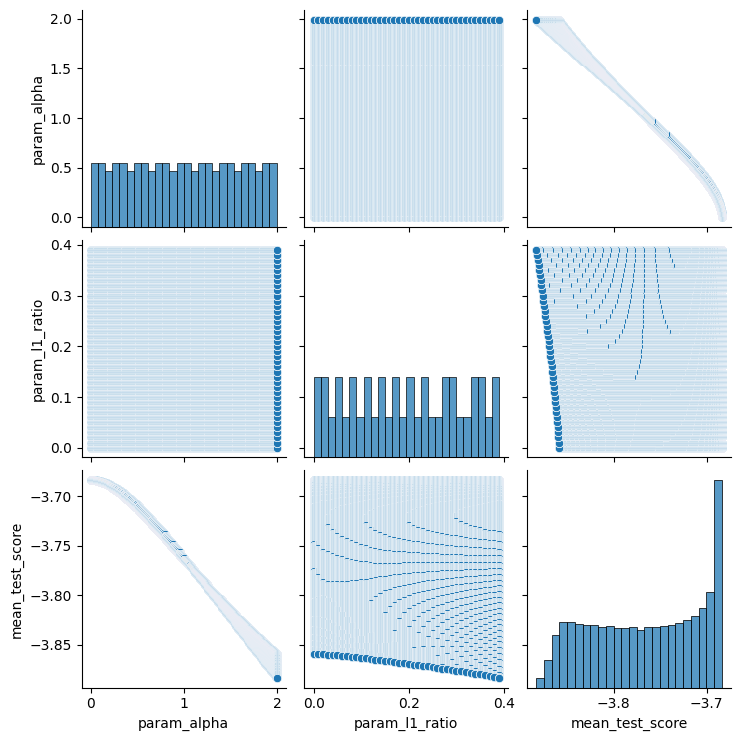

In [19]:
import seaborn as sns 
sns.pairplot(cv[['param_alpha','param_l1_ratio','mean_test_score']])
plt.show()

In [20]:
clf.best_estimator_.get_params()

{'alpha': 0.01,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.39,
 'max_iter': 10000,
 'positive': False,
 'precompute': False,
 'random_state': 41,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [21]:
cv[cv['mean_test_score']==max(cv['mean_test_score'])]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_intercept,param_l1_ratio,param_tol,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
158,0.001301,0.000060,0.000481,0.000010,0.01,True,0.39,0.0001,"{'alpha': 0.01, 'fit_intercept': True, 'l1_rat...",-3.963285,...,-3.683547,0.542655,1,-3.62693,-3.45393,-3.819732,-3.714446,-3.826177,-3.688243,0.138321
159,0.009721,0.016877,0.000483,0.000015,0.01,True,0.39,0.001,"{'alpha': 0.01, 'fit_intercept': True, 'l1_rat...",-3.963285,...,-3.683547,0.542655,1,-3.62693,-3.45393,-3.819732,-3.714446,-3.826177,-3.688243,0.138321


In [22]:
cv['param_alpha'].value_counts(dropna=False).sort_index()

0.00    80
0.01    80
0.02    80
0.03    80
0.04    80
        ..
1.95    80
1.96    80
1.97    80
1.98    80
1.99    80
Name: param_alpha, Length: 200, dtype: int64

## Evaluation

### Train 

In [23]:
predictions = clf.predict(x_trainC)

In [24]:
mse = sklearn.metrics.mean_squared_error(y_train,predictions)
mae = sklearn.metrics.mean_absolute_error(y_train,predictions)
r2 = sklearn.metrics.r2_score(y_train,predictions)
rmse = np.sqrt(mse)

In [25]:
train_output = pd.DataFrame({'Actual':y_train,'Prediction':predictions})
train_output['Team'] = train['TEAM_NAME']
train_output['Season'] = train['SEASON']
train_output.sort_values(['Season','Prediction'],inplace=True)
metrics_list = ['MSE','MAE','R2','RMSE']
values = [mse,mae,r2,rmse]
train_results = pd.DataFrame({'METRIC':metrics_list,'VALUE':values})
train_results = train_results.transpose().reset_index(drop=True)
train_results.columns = train_results.iloc[0,:]
train_results = train_results.tail(1)

In [26]:
train_output.tail()

,Actual,Prediction,Team,Season
295,7.0,5.090668,Bucks,2021
456,7.0,5.144881,Suns,2021
594,2.0,5.337362,Jazz,2021
249,0.0,5.917072,Lakers,2021
341,0.0,7.211399,Nets,2021


In [27]:
train_results

,MSE,MAE,R2,RMSE
1,13.645441,2.718933,0.269403,3.693974


### Test 

In [28]:
predictions = clf.predict(x_testC)

In [29]:
mse = sklearn.metrics.mean_squared_error(y_test,predictions)
mae = sklearn.metrics.mean_absolute_error(y_test,predictions)
r2 = sklearn.metrics.r2_score(y_test,predictions)
rmse = np.sqrt(mse)

In [30]:
test_output = pd.DataFrame({'Actual':y_test,'Prediction':predictions})
test_output['Team'] = test['TEAM_NAME']
test_output['Season'] = test['SEASON']
test_output.sort_values(['Season','Prediction'],inplace=True)
metrics_list = ['MSE','MAE','R2','RMSE']
values = [mse,mae,r2,rmse]
test_results = pd.DataFrame({'METRIC':metrics_list,'VALUE':values})
test_results = test_results.transpose().reset_index(drop=True)
test_results.columns = test_results.iloc[0,:]
test_results = test_results.tail(1)

In [31]:
test_output.head()

,Actual,Prediction,Team,Season
549,0.0,-1.203802,Thunder,2022
204,0.0,-0.887389,Rockets,2022
685,0.0,-0.296904,Hornets,2022
480,0.0,0.007105,Trail Blazers,2022
388,0.0,0.110750,Magic,2022


In [32]:
test_results

,MSE,MAE,R2,RMSE
1,13.145822,2.655448,0.286587,3.625717


### Upcoming Season 

In [33]:
drop_cols = ['TEAM_SEASON','TEAM_ID','TEAM_NAME','PO_WINS','SEASON']
x_up = upcoming.drop(drop_cols,axis=1)

In [34]:
x_up = sc.transform(x_up)
x_upC = pca.transform(x_up)

In [35]:
predictions = clf.predict(x_upC)
final_output = upcoming.copy()
final_output['Predicted Wins'] = predictions
final_output['Predicted Wins (Rounded)'] = [round(x) for x in predictions]
final_output['Team'] = upcoming['TEAM_NAME']
def rounds(x):
    if x < 4:
        return 'R1/Lottery'
    elif 4<=x<8:
        return 'Second Round'
    elif 8<=x<12: 
        return 'Conf. Finals'
    elif 12<=x<16:
        return 'Finals'
    elif x>=16:
        return 'Champions'
final_output['Round'] = [rounds(x) for x in final_output['Predicted Wins']]
final_output.sort_values('Predicted Wins',inplace=True)
fo = final_output[['Team','Predicted Wins','Predicted Wins (Rounded)','Round']]
fo

,Team,Predicted Wins,Predicted Wins (Rounded),Round
527,Spurs,-0.774965,-1,R1/Lottery
686,Hornets,-0.391448,0,R1/Lottery
550,Thunder,-0.319234,0,R1/Lottery
665,Pistons,-0.142186,0,R1/Lottery
205,Rockets,0.074682,0,R1/Lottery
481,Trail Blazers,0.593366,1,R1/Lottery
412,Pacers,0.775188,1,R1/Lottery
642,Wizards,1.053691,1,R1/Lottery
573,Raptors,1.323077,1,R1/Lottery
159,Nuggets,1.483130,1,R1/Lottery


In [36]:
len(list(final_output['Team']))

30

In [37]:
ec_teams = ['Hornets',
 'Wizards',
 'Hawks',
 'Pacers',
 'Magic',
 'Pistons',
 'Raptors',
 'Knicks',
 'Bulls',
 'Cavaliers',
 'Nets',
 '76ers',
 'Heat',
 'Celtics',
 'Bucks']
wc_teams = ['Thunder',
 'Rockets',
 'Spurs',
 'Trail Blazers',
 'Kings',
 'Pelicans',
 'Grizzlies',
 'Timberwolves',
 'Jazz',
 'Warriors',
 'Mavericks',
 'Lakers',
 'Clippers',
 'Suns',
 'Nuggets']

In [38]:
ec = fo[fo['Team'].isin(ec_teams)]
wc = fo[fo['Team'].isin(wc_teams)]

In [39]:
print("Bet to Win EC: ")
ecb = ec.sort_values('Predicted Wins').tail(4)
ecb

Bet to Win EC: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
113,Bulls,3.766766,4,R1/Lottery
435,76ers,4.523028,5,Second Round
45,Celtics,5.338913,5,Second Round
297,Bucks,5.580863,6,Second Round


In [40]:
print("Bet to Win WC: ")
wcb = wc.sort_values('Predicted Wins').tail(4)
wcb

Bet to Win WC: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
251,Lakers,3.339550,3,R1/Lottery
228,Clippers,4.006646,4,Second Round
182,Warriors,5.084359,5,Second Round
458,Suns,5.252651,5,Second Round


In [41]:
print("Bet to Win NBA Finals: ")
fob = fo.sort_values('Predicted Wins').tail(4)
fob

Bet to Win NBA Finals: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
182,Warriors,5.084359,5,Second Round
458,Suns,5.252651,5,Second Round
45,Celtics,5.338913,5,Second Round
297,Bucks,5.580863,6,Second Round


## Writing Info 

In [42]:
train_output['SUBSET'] = 'TRAIN'
test_output['SUBSET'] = 'TEST'
total_output = pd.concat([train_output,test_output])

In [43]:
train_results['SUBSET'] = 'TRAIN'
test_results['SUBSET'] = 'TEST'
total_results = pd.concat([train_results,test_results])
total_results

,MSE,MAE,R2,RMSE,SUBSET
1,13.645441,2.718933,0.269403,3.693974,TRAIN
1,13.145822,2.655448,0.286587,3.625717,TEST


In [44]:
model_name = input()

pcr_20231008


In [45]:
initial_path = ''
cv_path = initial_path+model_name+'_cv_results.csv'
output_path = initial_path+model_name+'_output.csv'
results_path = initial_path+model_name+'_results.csv'
predictions_path = initial_path+model_name+'_full_predictions.csv'
ec_path = initial_path+model_name+'_ecf_predictions.csv'
wc_path = initial_path+model_name+'_wcf_predictions.csv'
f_path = initial_path+model_name+'_finals_predictions.csv'
print(cv_path)
print(output_path)
print(results_path)
print(predictions_path)
print(ec_path)
print(wc_path)
print(f_path)

pcr_20231008_cv_results.csv
pcr_20231008_output.csv
pcr_20231008_results.csv
pcr_20231008_full_predictions.csv
pcr_20231008_ecf_predictions.csv
pcr_20231008_wcf_predictions.csv
pcr_20231008_finals_predictions.csv


In [46]:
cv.to_csv(cv_path,index=False)
total_output.to_csv(output_path,index=False)
total_results.to_csv(results_path,index=False)
fo.to_csv(predictions_path,index=False)
ecb.to_csv(ec_path,index=False)
wcb.to_csv(wc_path,index=False)
fob.to_csv(f_path,index=False)

In [47]:
import pickle

# save the model to disk
filename = model_name+'.sav'
pickle.dump(clf, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

## What if I had Used this Model Last Year? 

In [48]:
ec2 = test_output[test_output['Team'].isin(ec_teams)]
wc2 = test_output[test_output['Team'].isin(wc_teams)]

In [49]:
print("Bet to Win EC: ")
ecb2 = ec2.sort_values('Prediction').tail(4)
ecb2

Bet to Win EC: 


,Actual,Prediction,Team,Season,SUBSET
67,1.0,4.056235,Cavaliers,2022,TEST
44,11.0,4.372115,Celtics,2022,TEST
273,13.0,5.486485,Heat,2022,TEST
296,1.0,5.990615,Bucks,2022,TEST


In [50]:
print("Bet to Win WC: ")
wcb2 = wc2.sort_values('Prediction').tail(4)
wcb2

Bet to Win WC: 


,Actual,Prediction,Team,Season,SUBSET
181,6.0,4.740889,Warriors,2022,TEST
227,1.0,5.019328,Clippers,2022,TEST
158,16.0,5.626976,Nuggets,2022,TEST
457,6.0,6.382029,Suns,2022,TEST


In [51]:
print("Bet to Win NBA Finals: ")
fob2 = test_output.sort_values('Prediction').tail(4)
fob2

Bet to Win NBA Finals: 


,Actual,Prediction,Team,Season,SUBSET
273,13.0,5.486485,Heat,2022,TEST
158,16.0,5.626976,Nuggets,2022,TEST
296,1.0,5.990615,Bucks,2022,TEST
457,6.0,6.382029,Suns,2022,TEST
